This is the notebook where I will generate all climate-related figures for the first EB paper.

In [284]:
import xarray as xr 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import scipy.stats as ss
import copy
from scipy.stats import gaussian_kde

In [285]:
fp_MERRA = '/home/claire/research/climate_data/MERRA2/'
fp_AWS = '/home/claire/research/climate_data/AWS/'
fn_MERRA = fp_MERRA + 'VAR/MERRA2_VAR_60_-150.nc'
fn_MERRA_gp = fp_MERRA + 'MERRA2constants.nc4'
fn_CLAWS = fp_AWS + 'Preprocessed/gulkana2024.csv'
fn_nunatak = fp_AWS + 'gulkana/1725/LVL2/gulkana1725_hourly_LVL2_ALL.csv'
fn_ridge = fp_AWS + 'gulkana/1480/LVL2/gulkana1480_hourly_LVL2_ALL.csv'
store_quantiles_fn = '/home/claire/research/PyGEM-EB/data/quantile_mapping_VAR.csv'

# Gulkana location
lat = 63.5
lon = -145.625

# Spme constants
lapse_rate = -6.5
elev_CLAWS = 1682
elev_nunatak = 1725
elev_ridge = 1480
elev_MERRA2 = xr.open_dataarray(fn_MERRA_gp).sel(lat=lat,lon=lon).values[0] / 9.81

In [316]:
# Generate ALL files
df_all = None
for year in np.arange(2000,2025):
    if os.path.exists(fn_nunatak.replace('ALL',str(year))):
        df = pd.read_csv(fn_nunatak.replace('ALL',str(year)),index_col='UTC_time')
        if df_all is None:
            df_all = copy.deepcopy(df)
        else:
            df_all = pd.concat([df_all, df])
# df_all.to_csv(fn_nunatak)

### USEFUL FUNCTIONS

In [287]:
def quantile_mapping(data_MERRA,data_AWS,var=None):
    # Sort MERRA data and align AWS data accordingly
    sorted_indices = np.argsort(data_MERRA)
    data_MERRA_sorted = data_MERRA[sorted_indices]
    data_AWS_sorted = data_AWS[sorted_indices]

    # Compute empirical CDF
    reanalysis_cdf = (ss.rankdata(data_MERRA_sorted, method="average") - 1) / (len(data_MERRA_sorted) - 1)

    # Map MERRA quantiles to AWS quantiles
    quantile_map = np.interp(reanalysis_cdf, np.sort(reanalysis_cdf), np.sort(data_AWS_sorted))

    # Store data if executed with a var
    if var is not None:
        fn = store_quantiles_fn.replace('VAR',var)
        df = pd.DataFrame({'sorted': data_MERRA_sorted, 'mapping': quantile_map})
        df.to_csv(fn)

    return data_MERRA_sorted, quantile_map

def plot_quantile(X_train, y_train, X, y, lims):
    # Train quantile map
    sorted, mapping = quantile_mapping(X_train, y_train)

    # Plot it
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(8,3),gridspec_kw={'wspace':0.3})

    # Raw scatter
    ax1.scatter(X_train, y_train, s=3)
    ax1.plot(lims,lims,'k--',label='1:1')
    ax1.legend()
    ax1.set_xlabel('AWS',fontsize=11)
    ax1.set_ylabel('MERRA-2',fontsize=11)
    ax1.set_title('Raw training data (20%)')

    # Updated scatter
    if len(X) == len(y):
        updated = np.interp(X, sorted, mapping)
        all_updated = updated
    else:
        updated = np.interp(X_train, sorted, mapping)
        all_updated = np.interp(X, sorted, mapping)
    ax2.scatter(updated, y, s=3)
    ax2.plot(lims,lims,'k--',label='1:1')
    ax2.set_xlabel('AWS',fontsize=11)
    ax2.set_title('All adjusted data')

    # Distributions
    _,hist_bins = np.histogram(X)
    ax3.hist(X,histtype='step',label='Raw MERRA',linestyle='--',density=True)
    ax3.hist(all_updated,bins=hist_bins,histtype='step',label='Adj. MERRA',density=True)
    ax3.hist(y,bins=hist_bins,histtype='step',label='AWS',density=True)
    ax3.legend()
    ax3.set_title('Distributions')

    # All axes
    for ax in [ax1,ax2]:
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.tick_params(length=5)
    plt.show()

    return fig, (ax1,ax2,ax3)

## BIAS ADJUSTMENTS
### TEMPERATURE

In [333]:
temp_MERRA2 = xr.open_dataarray(fn_MERRA.replace('VAR','T2M')).sel(lat=lat,lon=lon)
temp_nunatak = pd.read_csv(fn_nunatak,index_col='UTC_time')['site_temp_USGS']
temp_CLAWS = pd.read_csv(fn_CLAWS,index_col=0)['temp']

# Adjust MERRA-2 to the same elevation as the nunatak
temp_MERRA2 += (elev_nunatak - elev_MERRA2) * lapse_rate / 1000

# Fix units
temp_MERRA2 -= 273.15

# Sort out time and find dates where AWS recorded temperature
temp_nunatak.index = pd.to_datetime(temp_nunatak.index) + pd.Timedelta(hours=5)
temp_CLAWS.index = pd.to_datetime(temp_CLAWS.index) + pd.Timedelta(hours=8)
dates_data = temp_nunatak.index[~np.isnan(temp_nunatak)]
dates_data = dates_data[dates_data >= pd.to_datetime('2000-01-01 00:00')]
dates_data = dates_data[dates_data <= pd.to_datetime('2024-08-31 00:00')]

# Select dates where AWS has data
temp_MERRA2 = temp_MERRA2.interp(time=pd.to_datetime(dates_data))
temp_nunatak = temp_nunatak.loc[dates_data]

# Correct nunatak temperature data to the on-ice AWS
# dates_2024 = np.sort(list(set(temp_CLAWS.index) & set(temp_nunatak.index)))
# temp_CLAWS = temp_CLAWS.loc[dates_2024].sort_index()
# temp_nunatak_2024 = temp_nunatak.loc[dates_2024] + (elev_CLAWS - elev_nunatak) * lapse_rate / 1000
# fig,ax = plt.subplots()
# ax.plot(dates_2024, temp_CLAWS, label='on-ice')
# ax.plot(dates_2024, temp_nunatak_2024,label='nunatak')
# ax.set_ylabel('Temperature ($\circ$C)')
# ax.legend()
# ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
# plt.show()

#### QUANTILE MAPPING

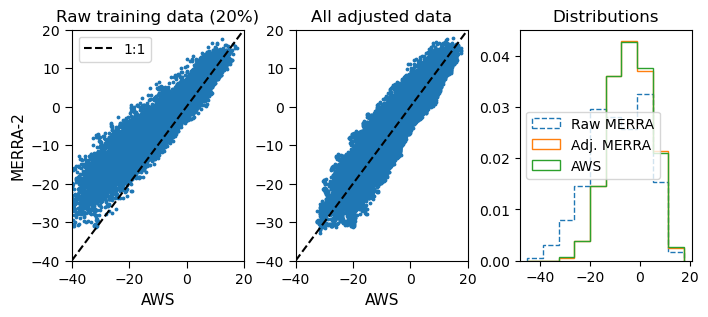

(<Figure size 800x300 with 3 Axes>,
 (<Axes: title={'center': 'Raw training data (20%)'}, xlabel='AWS', ylabel='MERRA-2'>,
  <Axes: title={'center': 'All adjusted data'}, xlabel='AWS'>,
  <Axes: title={'center': 'Distributions'}>))

In [337]:
# Separate data into train and test
X = temp_MERRA2.values
y = temp_nunatak.values

# Randomly select training data
num_indices = int(len(X) * 0.2)
train_indices = np.random.choice(len(X), size=num_indices, replace=False)
X_train = X[train_indices]
y_train = y[train_indices]

# Plot
lims = [-40, 20]
quantile_mapping(X_train, y_train, 'temp')
plot_quantile(X_train, y_train, X, y, lims)

### Incoming shortwave

In [330]:
SWin_MERRA2 = xr.open_dataarray(fn_MERRA.replace('VAR','SWGDN')).sel(lat=lat,lon=lon)
SWin_nunatak = pd.read_csv(fn_nunatak,index_col='UTC_time')['ShortwaveIn']

# Filter negative values
SWin_nunatak[SWin_nunatak < 0] = 0

# Sort out time and find dates where AWS recorded SWin
SWin_nunatak.index = pd.to_datetime(SWin_nunatak.index) + pd.Timedelta(hours=5)
dates_data = SWin_nunatak.index[~np.isnan(SWin_nunatak)]
dates_data = dates_data[dates_data >= pd.to_datetime('2000-01-01 00:00')]
dates_data = dates_data[dates_data <= pd.to_datetime('2024-08-31 00:00')]

# Select dates where AWS has data
SWin_MERRA2 = SWin_MERRA2.interp(time=pd.to_datetime(dates_data))
SWin_nunatak = SWin_nunatak.loc[dates_data]

# Fix units
SWin_MERRA2 *= 3600
SWin_nunatak *= 3600

In [331]:

# NUNATAK SEEMS TO BE OFF BY FIVE HOURS???
# df = pd.read_csv(fn_nunatak.replace('ALL','2014'),index_col='local_time')
# df2 = pd.read_csv('~/research/climate_data/AWS/Preprocessed/CLAWS_2024_alltime.csv',index_col=0)
# time = pd.date_range('2014-05-20','2014-07-20',freq='h')
# df.index = pd.to_datetime(df.index)
# df2.index = pd.to_datetime(df2.index)
# df = df.loc[time]
# df2 = df2.loc[pd.date_range('2024-05-20','2024-07-20',freq='h')]
# plt.scatter(df.index.hour, df['ShortwaveIn'])
# # df2
# plt.scatter(df2.index.hour, df2['SWin']/3600,label=)
# plt.xlabel('Time of day')
# plt.ylabel('Solar radiation (W/m2)')


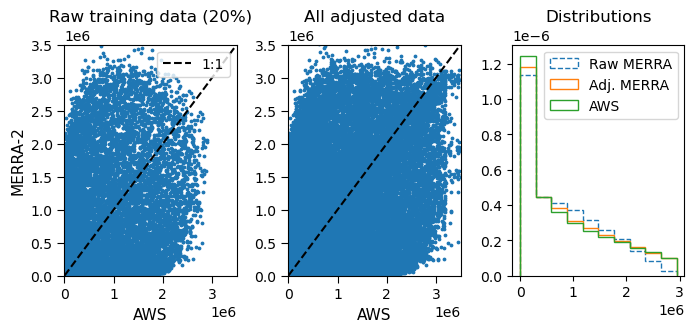

In [332]:
# Filter 0s
index_not0 = np.where((SWin_MERRA2.values > 0) & (SWin_nunatak > 0))[0]
SWin_MERRA2 = SWin_MERRA2.isel(time=index_not0)
SWin_nunatak = SWin_nunatak.iloc[index_not0]

# Separate data into train and test
X = SWin_MERRA2.values
y = SWin_nunatak.values

# Get dates to train on 
dates_train = SWin_nunatak.loc[pd.to_datetime('2017-01-01'):pd.to_datetime('2021-01-01')].index
X_train = SWin_MERRA2.sel(time=dates_train).values
y_train = SWin_nunatak.loc[dates_train].values

# Save quantiles
quantile_mapping(X_train, y_train, 'SWin')

# Plot 
fig, (ax1,ax2,ax3) = plot_quantile(X_train, y_train, X, y, [0,3.5e6])
ax3.set_xlabel('Incoming shortwave')
fig.suptitle('Incoming shortwave radiation ($J m^{-2}$)')
plt.show()

### WIND SPEED

In [338]:
uwind_MERRA2 = xr.open_dataarray(fn_MERRA.replace('VAR','U2M')).sel(lat=lat,lon=lon)
vwind_MERRA2 = xr.open_dataarray(fn_MERRA.replace('VAR','V2M')).sel(lat=lat,lon=lon)
wind_MERRA2 = uwind_MERRA2.copy(deep=True)
all_wind = np.sqrt(np.square(uwind_MERRA2.values) + np.square(vwind_MERRA2.values))
wind_MERRA2.values = all_wind
wind_CLAWS = pd.read_csv(fn_CLAWS,index_col=0)['uwind']

# Sort out time and find dates where AWS recorded wind speed
wind_CLAWS.index = pd.to_datetime(wind_CLAWS.index) + pd.Timedelta(hours=5)
dates_data = wind_CLAWS.index[~np.isnan(wind_CLAWS)]
dates_data = dates_data[dates_data >= pd.to_datetime('2000-01-01 00:00')]
dates_data = dates_data[dates_data <= pd.to_datetime('2024-08-31 00:00')]

# Select dates where AWS has data
wind_MERRA2 = wind_MERRA2.interp(time=pd.to_datetime(dates_data))
wind_CLAWS = wind_CLAWS.loc[dates_data]

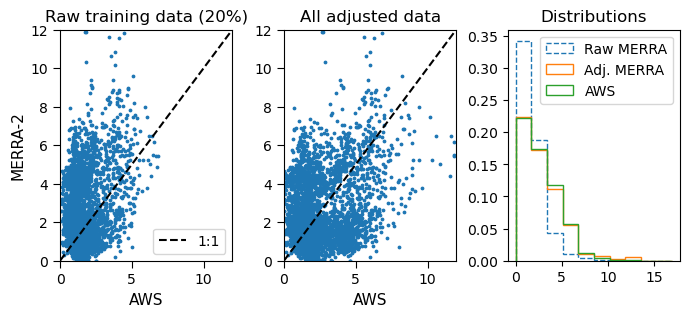

In [339]:
# All data
X = all_wind
y = wind_CLAWS.values

# Training data is ALL the 2024 summer
X_train = wind_MERRA2.values
y_train = wind_CLAWS.values

# Save quantiles
quantile_mapping(X_train, y_train, 'wind')

# Plot
lims = [0, 12]
fig, axes = plot_quantile(X_train, y_train, X, y, lims)
plt.show()

(Temperature Linear Regression)

In [ ]:
# Perform regression on all nunatak and MERRA-2 temperatures
X = np.vstack([temp_MERRA2.values, np.ones_like(temp_MERRA2.values)]).T
y = temp_nunatak.values
result,resid = np.linalg.lstsq(X,y,rcond=None)[:2]
slope = result[0]
intercept = result[1]

# Plot it
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

# Raw
ax1.scatter(temp_MERRA2.values, temp_nunatak.values, s=3)
xrange = np.linspace(-40,20,200)
ax1.plot(xrange,xrange*slope + intercept,'r:',label=f'$y={slope:.3f}x+{intercept:.3f}$')
ax1.plot([-30,20],[-30,20],'k--',label='1:1')
ax1.legend()
ax1.set_title('Raw data and linear fit')

# Updated
ax2.scatter(temp_MERRA2.values * slope + intercept, temp_nunatak.values, s=3)
ax2.plot([-30,20],[-30,20],'k--',label='1:1')
ax2.legend()
ax2.set_title('Adjusted data')

# Both
for ax in [ax1,ax2]:
    ax.set_xlim(-30,20)
    ax.set_ylim(-30,20)
    ax.tick_params(length=5)
plt.show()